<div class="jumbotron jumbotron-fluid">
  <div class="container">
    <h1 class="display-4">Having Fun with Python: World Population Analysis</h1>
    <p class="lead">Extra Credit Homework Assignment</p>
    
  </div>
</div>

<div class="card mb-3" style="max-width: 540px;">
  <div class="row no-gutters">
    <div class="col-md-4">
      <img src="Data/English/Scanned_documents/t2.tif" class="card-img" alt="...">
    </div>
    <div class="col-md-8">
      <div class="card-body">
        <h5 class="card-title">Task</h5>
        <p class="card-text">Extract data from a "World Population" PDF. unfortunately the client was only able to obtain a copy of the data and no time to request another format. Analysis needs to be done using Python Pandas</p>
        <p class="card-text"><small class="text-muted">Use: Pandas, Regex, and Plotting</small></p>
      </div>
    </div>
  </div>
</div>


Overall Steps:
* Convert image data to string (OCR)
* User Regex for Data Cleanup and Extraction
* Convert data to a Pandas DataFrame
* Plotting
* Final Analysis



# 1. Load Our Libraries

Before we start let's make sure we have all the libraries installed and loaded. If you don't have these installed from a prior exercise you can run from your terminal

```bash
pip install -r requirements.txt
```

or


```bash
conda install --yes -c conda-forge --file requirements.txt
```

In this assignment we wil be using:
* `tabula`: is actually a python wrapper to `tabula java` which a library for extracting tables from PDF files
* `pytesseract`: Python-tesseract is a wrapper for [Google's Tesseract-OCR Engine](https://github.com/tesseract-ocr/tesseract).
* `PIL`: Python Imaging Library (PIL) adds image processing capabilities to your Python interpreter. This library supports many file formats, and provides powerful image processing and graphics capabilities.
* `pandas`: Easy-to-use data structures and data analysis tools in Python
* `re`:  a Python module which provides regular expression matching operations

In [145]:
import pdf2image
import tabula
import pytesseract
import PIL
import pandas as pd
import matplotlib.pyplot as plt
import re
# import img2pdf

## Let's explore `tabula` library and see it is used in general
* `tabula.environment_info()` shows environment information for reporting. Returns detailed information like Python version, Java version, or OS environment, etc. Let's see it in action:

In [2]:
tabula.environment_info()

Python version:
    3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Java version:
    java version "1.8.0_221"
Java(TM) SE Runtime Environment (build 1.8.0_221-b11)
Java HotSpot(TM) 64-Bit Server VM (build 25.221-b11, mixed mode)
tabula-py version: 1.4.1
platform: Windows-10-10.0.17763-SP0
uname:
    uname_result(system='Windows', node='CA-JUSTFOUST-LT', release='10', version='10.0.17763', machine='AMD64', processor='Intel64 Family 6 Model 142 Stepping 10, GenuineIntel')
linux_distribution: ('', '', '')
mac_ver: ('', ('', '', ''), '')
    


### Use `tabula` to read a PDF file and convert it into a `panda.DataFrame`
Example: We have `Q3 FY19 Consolidated Financial Statements.pdf` which is Apple's latest Financial Report, which has multiple pages. By default, tabula will read the first page, which is fine for our testing. Let's see it in action before we run it on `worldpopulation.pdf` since this financial statement is nicely formatted and gives us a feeling on how this library works.

In [3]:
apple_df = tabula.read_pdf("Data/Q3 FY19 Consolidated Financial Statements.pdf")
apple_df.head()

,Unnamed: 0,Unnamed: 1,"June 29,",Unnamed: 3,"June 30,",Unnamed: 5,"June 29,.1",Unnamed: 7,"June 30,.1"
0,NaN,NaN,2019,NaN,2018,NaN,2019,NaN,2018
1,Net sales:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Products,$,"42,354 $",NaN,"43,095 $",NaN,"162,354 $",NaN,"173,546"
3,Services,NaN,"11,455",NaN,"10,170",NaN,"33,780",NaN,"29,149"
4,Total net sales (1),NaN,"53,809",NaN,"53,265",NaN,"196,134",NaN,"202,695"


The headers are not correct, and we probably need to make some adjustments. If we examing the documentation we see `pandas_options={'header': None}` option. Let's give it try:

In [4]:
apple_df = tabula.read_pdf("Data/Q3 FY19 Consolidated Financial Statements.pdf", pandas_options={'header':None})
apple_df.head(10)

,0,1,2,3,4,5,6,7,8
0,NaN,NaN,"June 29,",NaN,"June 30,",NaN,"June 29,",NaN,"June 30,"
1,NaN,NaN,2019,NaN,2018,NaN,2019,NaN,2018
2,Net sales:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Products,$,"42,354 $",NaN,"43,095 $",NaN,"162,354 $",NaN,"173,546"
4,Services,NaN,"11,455",NaN,"10,170",NaN,"33,780",NaN,"29,149"
5,Total net sales (1),NaN,"53,809",NaN,"53,265",NaN,"196,134",NaN,"202,695"
6,Cost of sales:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Products,NaN,"29,473",NaN,"28,956",NaN,"109,758",NaN,"113,467"
8,Services,NaN,"4,109",NaN,"3,888",NaN,"12,297",NaN,"11,473"
9,Total cost of sales,NaN,"33,582",NaN,"32,844",NaN,"122,055",NaN,"124,940"


We diffentely need to do more work to clean this up. But this is not our task, we need to read `worldpopulation.pdf`. 

## Q1: Use `tabula` to read and convert the pdf into a dataframe (5pts)

In [5]:
import os

def pdf2panda(file):
    ## Your code
    df = tabula.read_pdf(file, pandas_options={'header':None})
    
    return df

In [6]:
#Test Data/English/Scanned_documents/worldpopulations.pdf
file = os.path.join("Data", "English", "Scanned_documents", "worldpopulations.pdf")
output = pdf2panda(file)
print(output)

The output file is empty.


None


If the output says `file is empty` then we know `tabula` is not a good choice. Mainly, because this PDF obiously was created from an image which means we need to figure out other options

# 2. Extracting our Text 

## Explore other options with `pytesseract` 
To use `pytesseract` OCR we first need to convert ther PDF to an image, and then use the OCR to extract text from that image. 

* We will use `pdf2image` library to convert the PDF into an image
* Use `pytesseract` to extract text from that image

Let's try this using the Apple data for a test run. 

In [8]:
pages = pdf2image.convert_from_path("Data/Q3 FY19 Consolidated Financial Statements.pdf")
for page in pages:
    page.save('apple.jpg', 'JPEG')

To validate we can open the image using `PIL.Image.open` as in below:

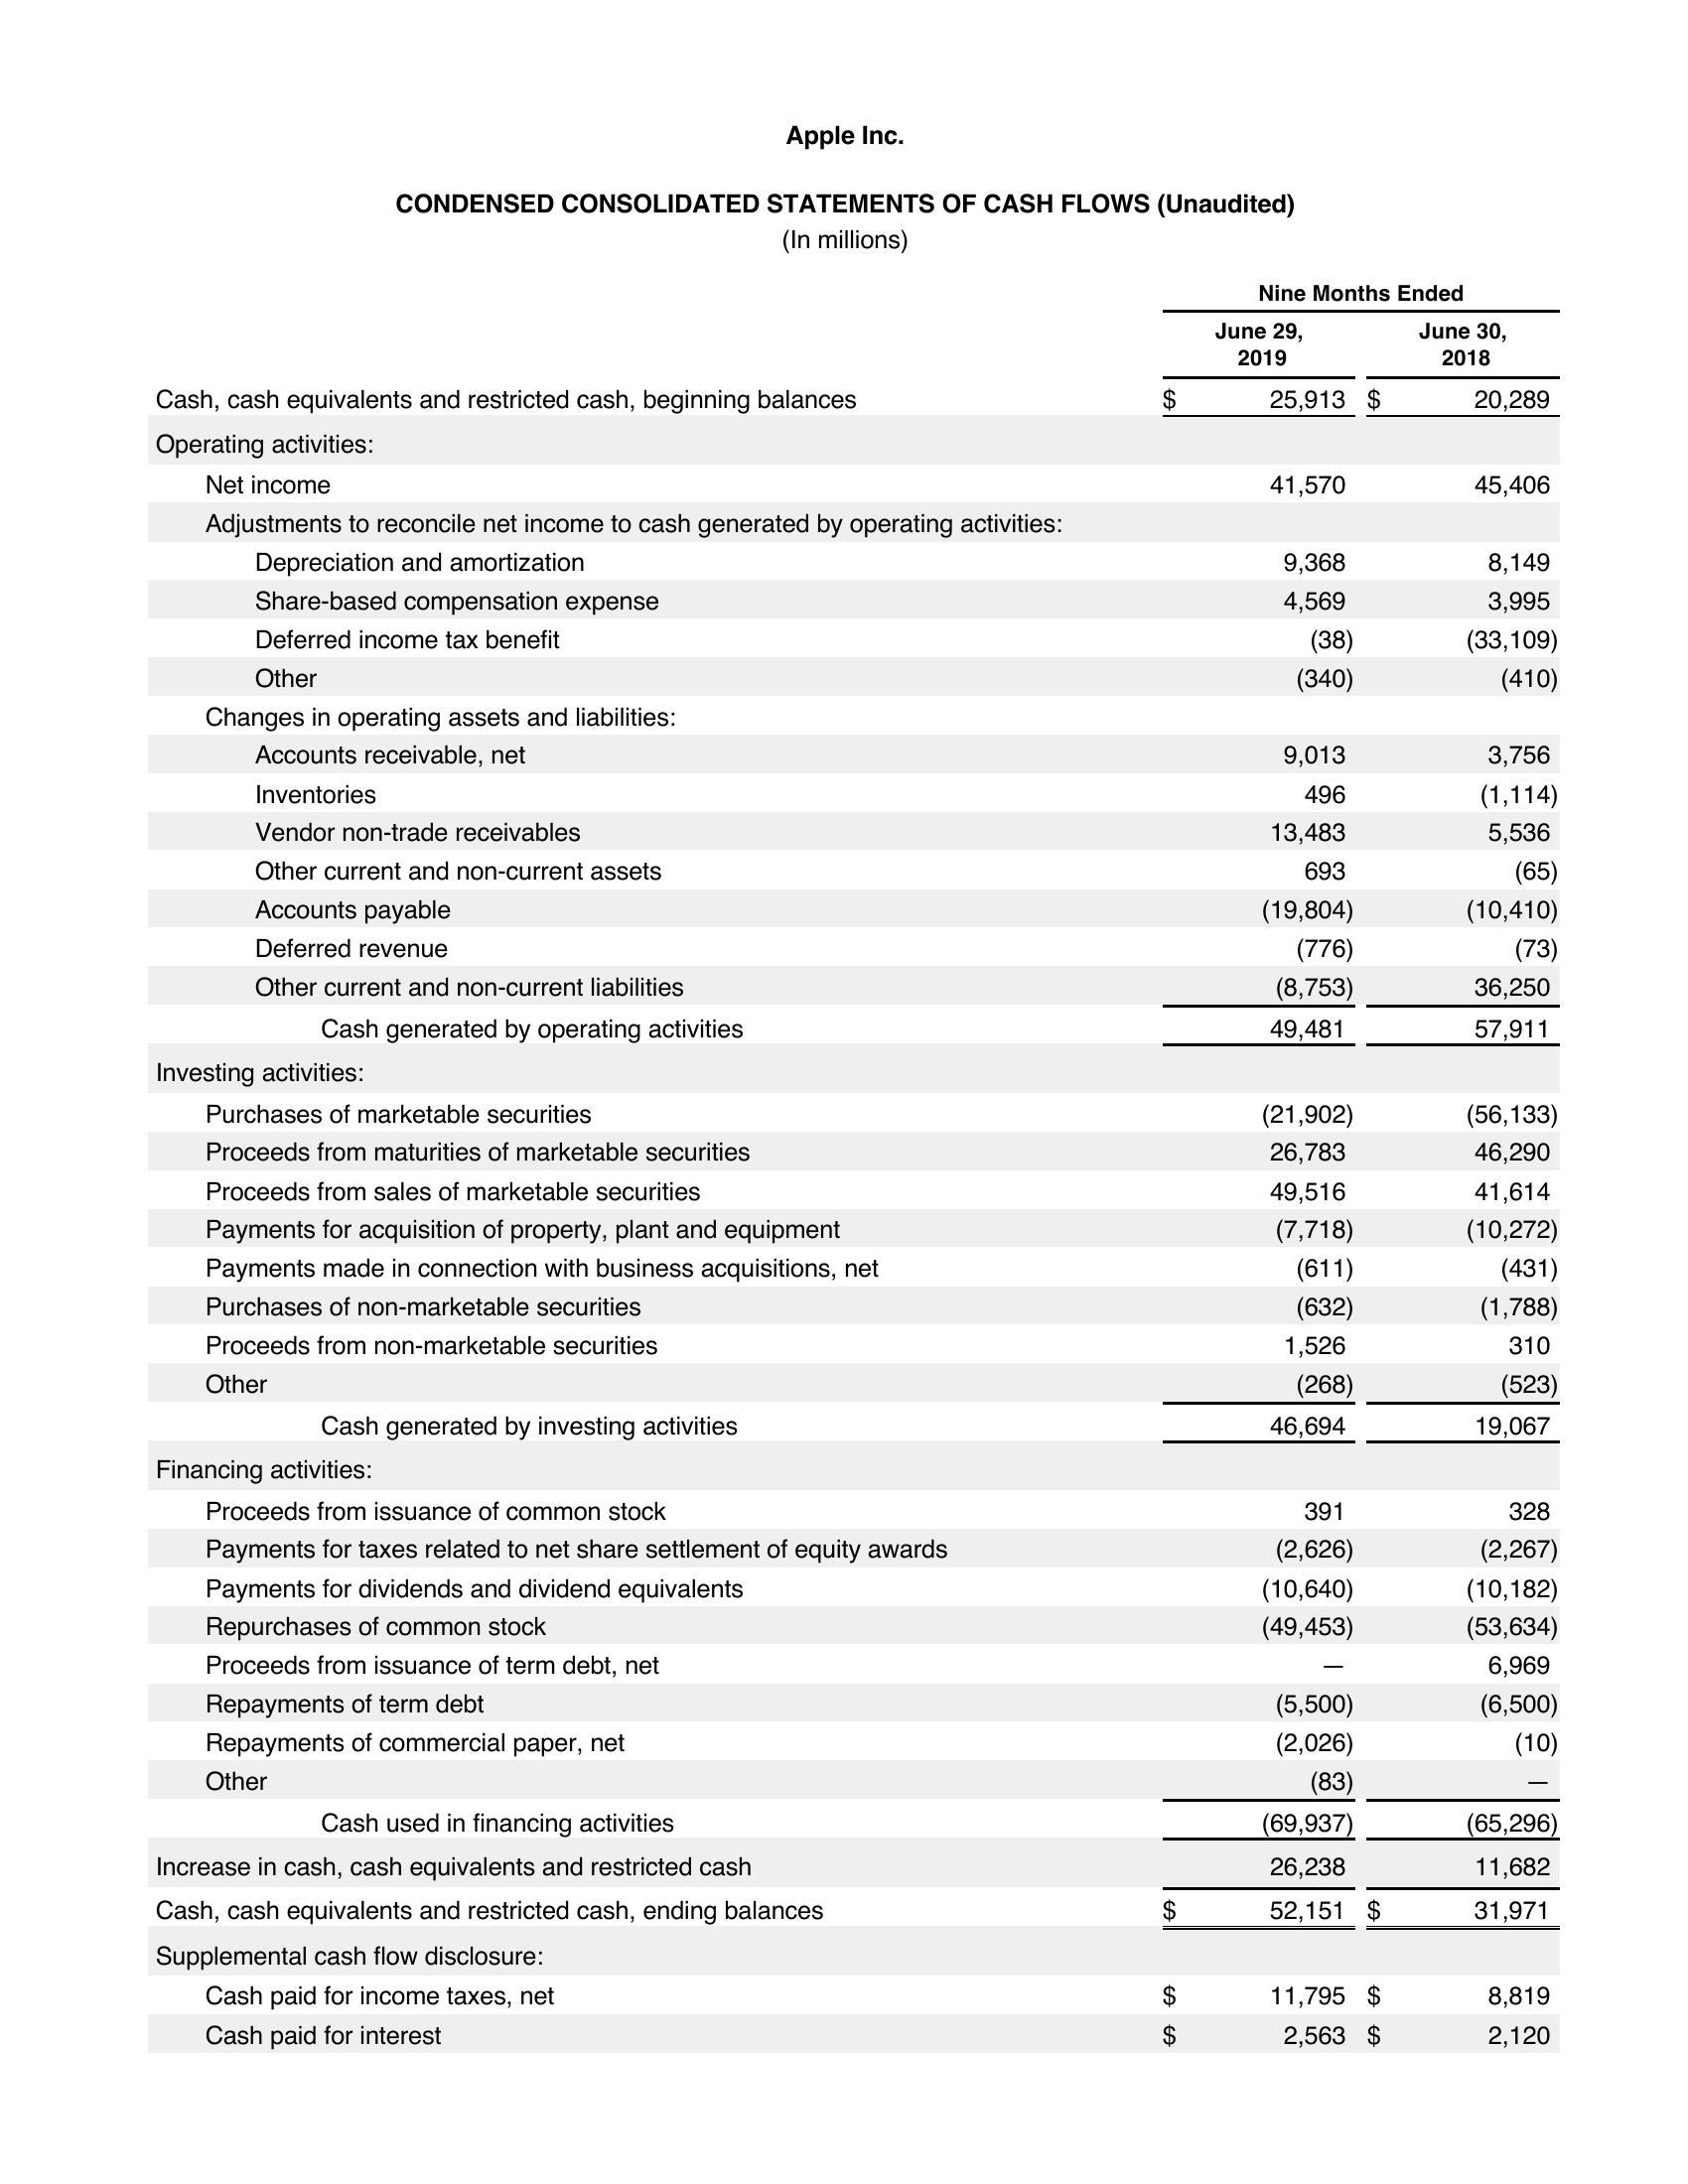

In [9]:
PIL.Image.open('apple.jpg')

Generally, `pdf2image` returns a PIL iterable object. We can actually pass it directly to `pytesseract` and skip the need to save that image. Let's see that in action:

In [10]:
pages = pdf2image.convert_from_path("Data/Q3 FY19 Consolidated Financial Statements.pdf")
for content in pages:
    print(pytesseract.image_to_string(content))

Apple Inc.

CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited)
(In millions, except number of shares which are reflected in thousands and per share amounts)

 

 

 

 

 

 

 

 

Three Months Ended Nine Months Ended
June 29, June 30, June 29, June 30,
2019 2018 2019 2018
Net sales:
Products $ 42,354 $ 43,095 $ 162,354 $ 173,546
Services 11,455 10,170 33,780 29,149
Total net sales “) 53,809 53,265 196,134 202,695
Cost of sales:
Products 29,473 28,956 109,758 113,467
Services 4,109 3,888 12,297 11,473
Total cost of sales 33,582 32,844 122,055 124,940
Gross margin 20,227 20,421 74,079 77,755
Operating expenses:
Research and development 4,257 3,701 12,107 10,486
Selling, general and administrative 4,426 4,108 13,667 12,489
Total operating expenses 8,683 7,809 25,774 22,975
Operating income 11,544 12,612 48,305 54,780
Other income/(expense), net 367 672 1,305 1,702
Income before provision for income taxes 11,911 13,284 49,610 56,482
Provision for income taxes 1,867 1,765 8,040 1

## Q2: Write a function that converts a PDF into an image and then pass it to the OCR. The function should return a list (5 pts)


In [11]:
def convertPDF(pdffile):
    ## ADD YOUR CODE
    data = []
    file = pdf2image.convert_from_path(pdffile)
    for page in file:
        data.append(pytesseract.image_to_string(page))
    
    ## return a python list that contains data extract per page
    
    return data
    

In [12]:
#test 1
file = os.path.join("Data", "Q3 FY19 Consolidated Financial Statements.pdf")
imagesdata = convertPDF(file)
print(f'number of images processed = {len(imagesdata)}')
print(imagesdata)

number of images processed = 3
['Apple Inc.\n\nCONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited)\n(In millions, except number of shares which are reflected in thousands and per share amounts)\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nThree Months Ended Nine Months Ended\nJune 29, June 30, June 29, June 30,\n2019 2018 2019 2018\nNet sales:\nProducts $ 42,354 $ 43,095 $ 162,354 $ 173,546\nServices 11,455 10,170 33,780 29,149\nTotal net sales “) 53,809 53,265 196,134 202,695\nCost of sales:\nProducts 29,473 28,956 109,758 113,467\nServices 4,109 3,888 12,297 11,473\nTotal cost of sales 33,582 32,844 122,055 124,940\nGross margin 20,227 20,421 74,079 77,755\nOperating expenses:\nResearch and development 4,257 3,701 12,107 10,486\nSelling, general and administrative 4,426 4,108 13,667 12,489\nTotal operating expenses 8,683 7,809 25,774 22,975\nOperating income 11,544 12,612 48,305 54,780\nOther income/(expense), net 367 672 1,305 1,702\nIncome before provision for income taxes 11

In [13]:
# test 2
file = os.path.join("Data", "English", "Scanned_documents", "worldpopulations.pdf")
imagesdata = convertPDF(file)
print(f'number of images processed = {len(imagesdata)}')
print(imagesdata)

number of images processed = 1
['Demographic data and estimates Area, Density, Capital City\n\n \n\n \n\n \n\n \n\nProjected — Percent of Life\nPopulation Population Population of Expectancy Pop. per\nMid-2002 (millions) Age at Birth area of Countries Square\n(millions) 2025 «<15.—s« 65+ (years) (square miles) Mile Capital City\nWORLD 6215 7,859 30 7 ea 51,789,601 120\n| 1197 1.249 18 15 76 19,814,584 60\n5.018 661 33 5 65 31,975,017 157\n= 741.2 96.1 36 4 66 386,66 184 Cairo\npaul 129.9 2045 44 3 52 356,668 364 Abuja\nS = ez 117.6 BANS 52 426,371 159 Addis Ababa\nrn wz 37.2 598 45. 3 52 364,9 102 Dodoma\na 55.2 106.0 48 3 49 905,351 61 Kinshasa\n= 43.6 35.1 34.5 51 471,444 93 Pretoria\nI¥l 31.3 36.0 19 13 79 3,849,670 8 Ottawa\n< 2874 346.0 21. 13 77 3,717,796 77 Washington, DC\nz Le 101.7 131.7 33.5 75 756,062 135 Mexico Cit\nFo 36.5 47.2 28 10 74 1,073,514 34 Buenos Aires\n< fs) 173.8 219.0 30 6 69 3,300,154 53 ___ Brasilia\nmem | Colombia 43.8 50.7 33.5 71 439,734. 100 Bogota\n32 4

## Q3: Display the image (5 pts)
We also have the image in a higher resolution format. After investigating the quality of the OCR above (notice for example Egypt and some countries are missing), is that the PDF was actually created from an Image. So convering back to an image reduced the quality. Let's examine the image that the analyst forgot to share with us.

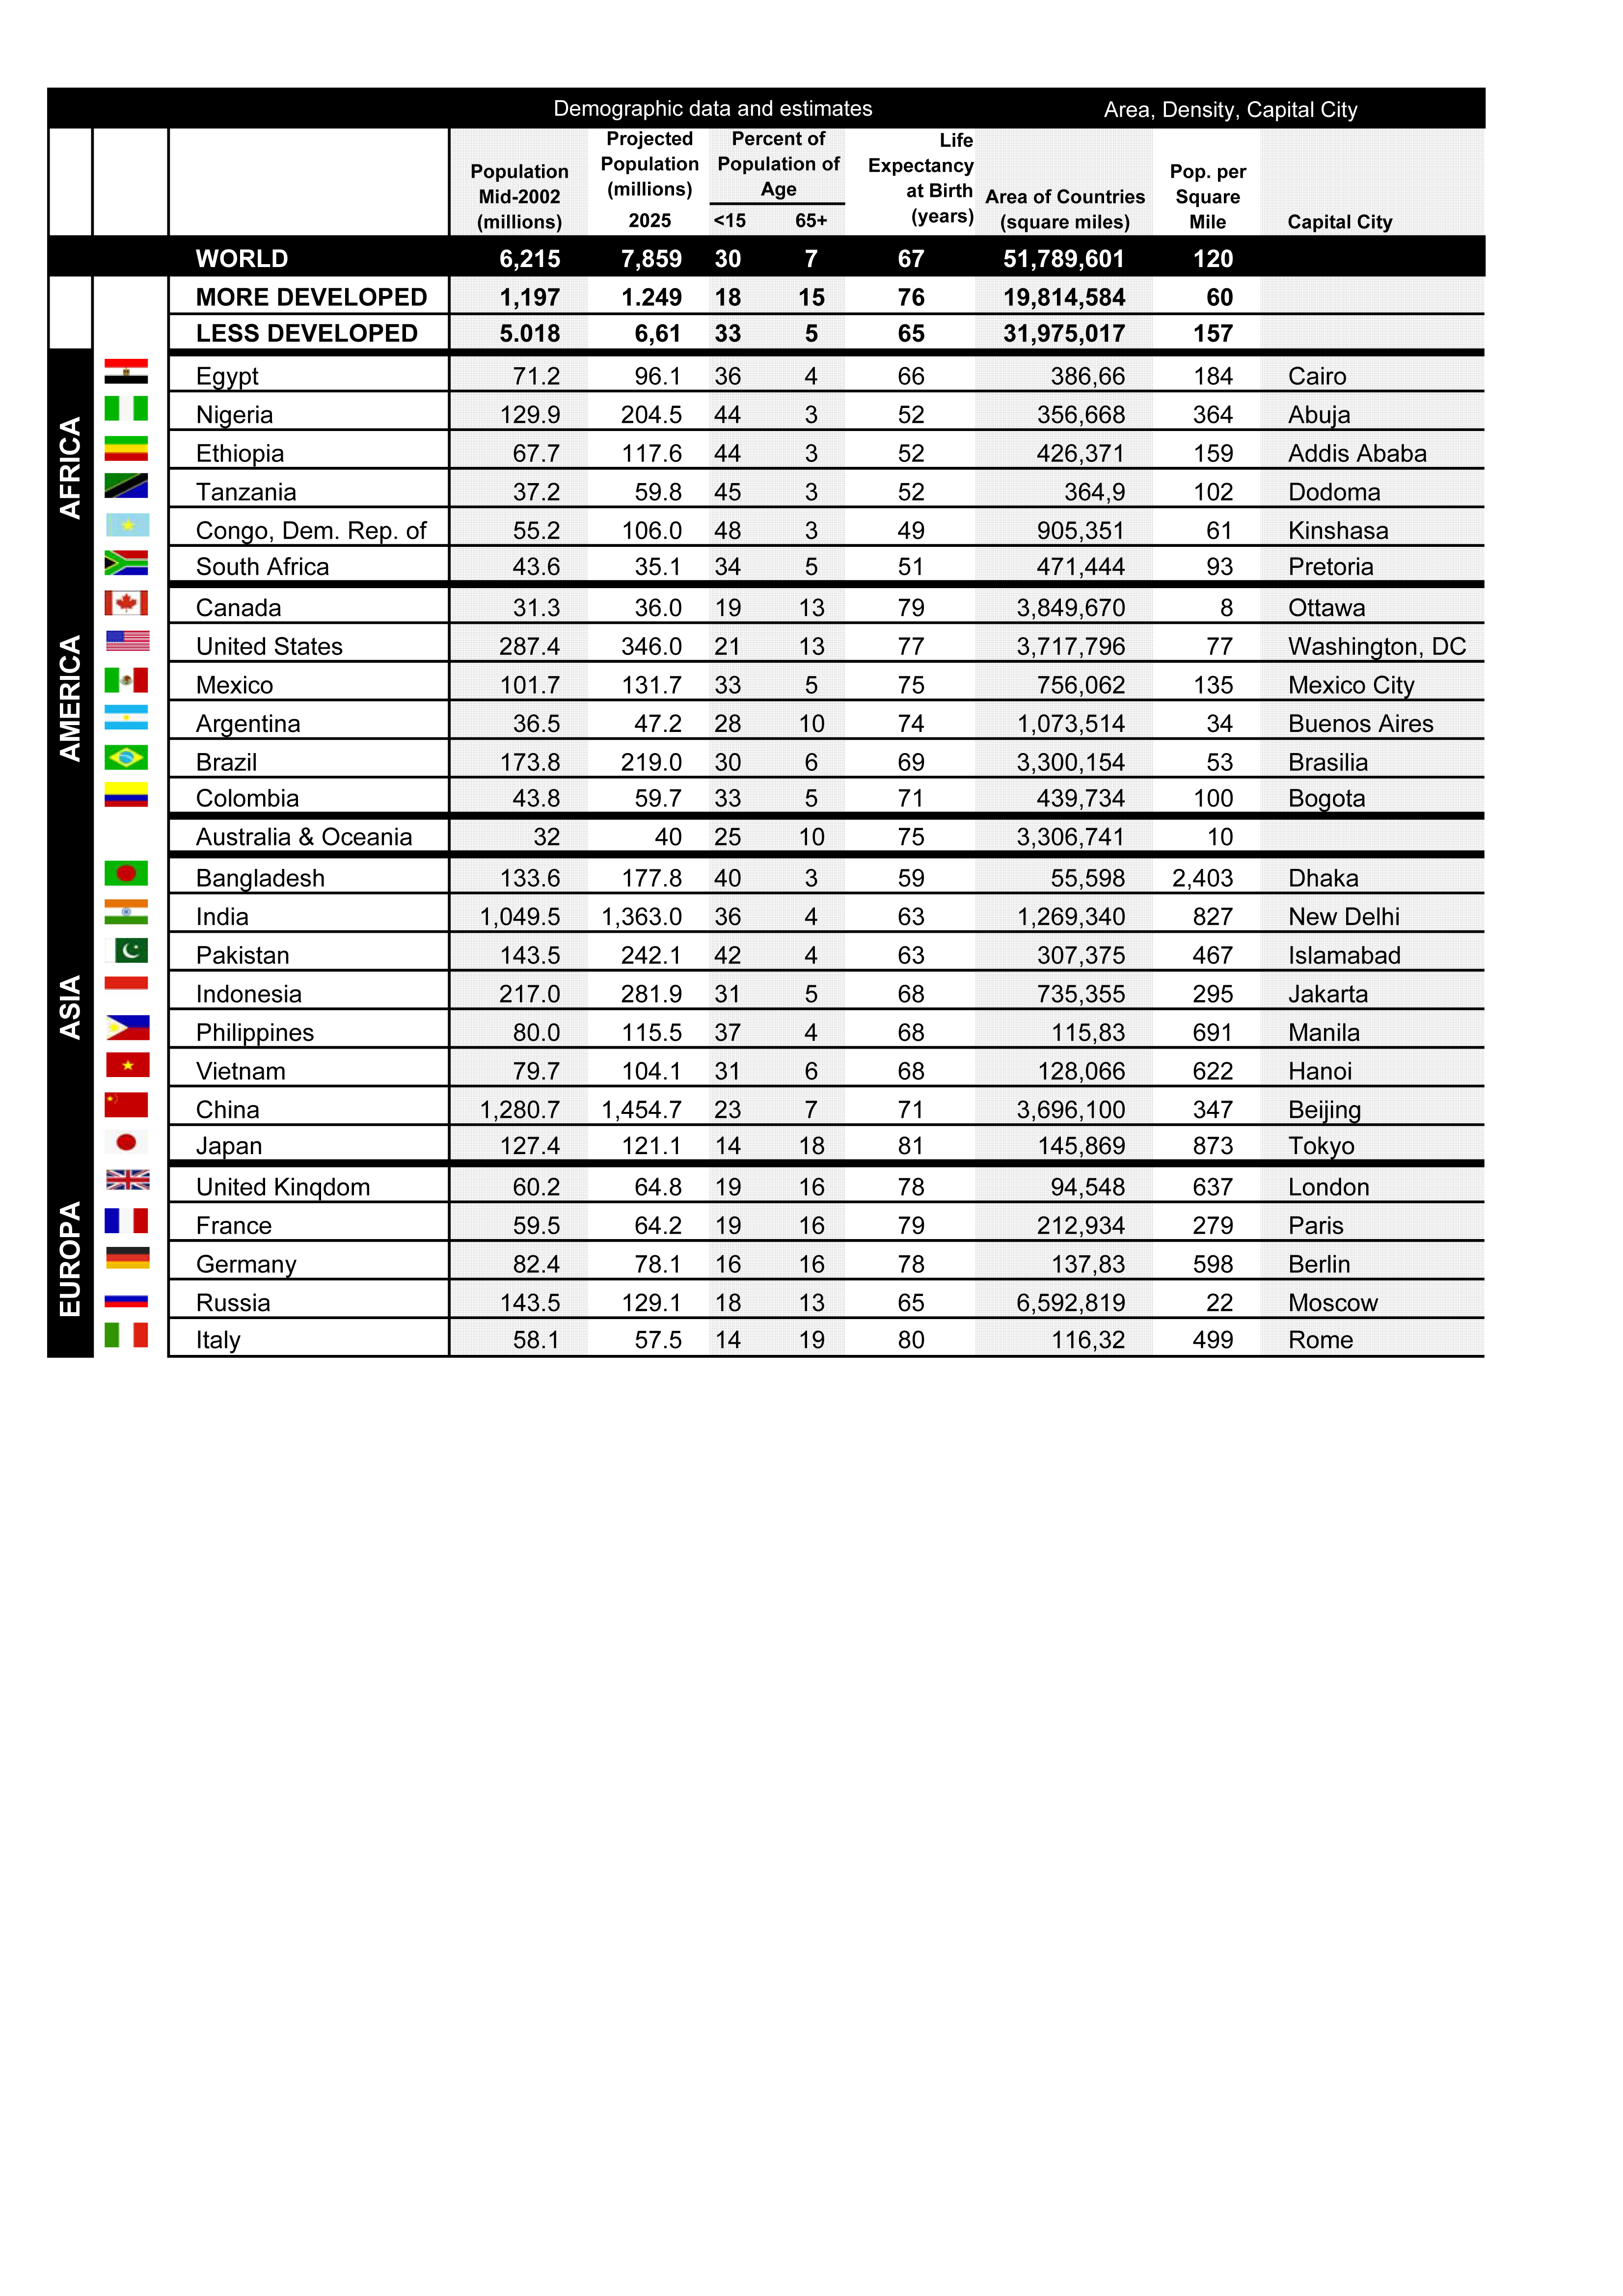

In [15]:
file = os.path.join("Data", "English", "Scanned_documents", "t2.tif")
## YOUR CODE HERE
PIL.Image.open(file)

We will apply OCR again and compare the quality of the outcoome

In [16]:
data = pytesseract.image_to_string(file)
data

'Demographic data and estimates Area, Density, Capital City\n\n \n\n \n\n \n\n \n\n \n\n \n\nVat e7.\n\n \n\n \n\n€\n\n \n\n \n\n \n\n \n\nAMERICA\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nASIA\n\n \n\n \n\n \n\nHOM IGHE PONSA\n\n \n\nNY\n“iit\n\n \n\n \n\n \n\nEUROPA\nIi\n\n \n\n \n\nProjected Percent of Life\n\nPopulation Population Population of Expectancy Pop. per\n\nMid-2002 ~=—(millions) Age at Birth Area of Countries Square\n\n(millions) 2025 <15 65+ (years) (square miles) Mile Capital City\nWORLD 6,215 7,859 30 7 oy 4 51,789,601 120\nMORE DEVELOPED 1,197 1.249 18 15 76 19,814,584 60\nLESS DEVELOPED 5.018 6,61 33 5 65 31,975,017 157\nEgypt 11.2 96.1 36 4 66 386,66 184 Cairo\nNigeria 129.9 204.5 44 o 52 356,668 364 Abuja\nEthiopia 67.7 117.6 44 3 52 426,371 159 Addis Ababa\nTanzania 37.2 59.8 45 3 52 364,9 102 Dodoma\nCongo, Dem. Rep. of 562 106.0 48 3 49 905,351 61 Kinshasa\nSouth Africa 43.6 35.1 34 5 51 471,444 93 Pretoria\nCanada 31.3 36.0 19 13 79 3,849,670 8 Ottawa\nUnited Stat

## Q4 was there any difference? (5 pts)
Compare the length between the two outputs. Which one was higher?

In [21]:
len(imagesdata[0])

1545

In [22]:
#Your Code HERE
print(f'Output from TIF format = {len(data)}')
print(f'Output from PDF format = {len(imagesdata[0])}')

Output from TIF format = 1834
Output from PDF format = 1545


## 3. Extracting data into a DataFrame
We can see there is a lot of `\n`, in order to view it in an easier to read format we can use print. Remember, this is a python list that we got back.

In [23]:
print(data)

Demographic data and estimates Area, Density, Capital City

 

 

 

 

 

 

Vat e7.

 

 

€

 

 

 

 

AMERICA

 

 

 

 

 

 

 

ASIA

 

 

 

HOM IGHE PONSA

 

NY
“iit

 

 

 

EUROPA
Ii

 

 

Projected Percent of Life

Population Population Population of Expectancy Pop. per

Mid-2002 ~=—(millions) Age at Birth Area of Countries Square

(millions) 2025 <15 65+ (years) (square miles) Mile Capital City
WORLD 6,215 7,859 30 7 oy 4 51,789,601 120
MORE DEVELOPED 1,197 1.249 18 15 76 19,814,584 60
LESS DEVELOPED 5.018 6,61 33 5 65 31,975,017 157
Egypt 11.2 96.1 36 4 66 386,66 184 Cairo
Nigeria 129.9 204.5 44 o 52 356,668 364 Abuja
Ethiopia 67.7 117.6 44 3 52 426,371 159 Addis Ababa
Tanzania 37.2 59.8 45 3 52 364,9 102 Dodoma
Congo, Dem. Rep. of 562 106.0 48 3 49 905,351 61 Kinshasa
South Africa 43.6 35.1 34 5 51 471,444 93 Pretoria
Canada 31.3 36.0 19 13 79 3,849,670 8 Ottawa
United States 287.4 346.0 21 13 77 3,/17,796 77 Washington, DC
Mexico 101.7 131.7 33 5 75 756,062 135 M

### Extracting Data using Regular Expressions `re`

There are many ways to use Regular Expression to come up with a propoer logic. We want to pick a simple solution to get us to what we want. In our case, we want a DataFrame that looks like this:

<img src='images/dataframe.png' width="500"/>

We don't need any of the data before `Egypt`. We need to capture all the data between `Egypt` to `Rome` according the text structure. Here is an example below:

In [24]:
guestlist = "This is a list of the top 3 guests that attended the event, I am sendig it based on your request\nJohn Smith\nJames Bond\nJack Back\nLet me know if you need anything else"
print(guestlist)

This is a list of the top 3 guests that attended the event, I am sendig it based on your request
John Smith
James Bond
Jack Back
Let me know if you need anything else


In [26]:
regex = re.compile(r'(John|Back)')
matches = regex.finditer(guestlist)

for match in matches:
    print(match)
                   

<re.Match object; span=(97, 101), match='John'>
<re.Match object; span=(124, 128), match='Back'>


In [27]:
# I Can store these in a list
regex = re.compile(r'(John|Back)')
matches = regex.finditer(guestlist)
idx = []
for match in matches:
    idx.append([match.start(), match.end()])
idx

[[97, 101], [124, 128]]

So, this gave me the begining index (97) and ending index (128). What if I use that to slice the big chunk I need to work on?

In [28]:
smaller = guestlist[idx[0][0]:idx[1][1]]
print(smaller)

John Smith
James Bond
Jack Back


## Q5 Extract a slice of data that containt the table information using regex (15 pts)

In [30]:
## Your Code Here 
regex = re.compile(r'(Egypt|Rome)')
matches = regex.finditer(data)
idx = []
for match in matches:
    idx.append([match.start(), match.end()])

In [31]:
# You should get something like this
print(idx)

[[560, 565], [1830, 1834]]


In [32]:
# test your results
# my new data slice should be 
dataslice = data[idx[0][0]:idx[1][1]]

In [33]:
# Example result outcome 
print(dataslice)

Egypt 11.2 96.1 36 4 66 386,66 184 Cairo
Nigeria 129.9 204.5 44 o 52 356,668 364 Abuja
Ethiopia 67.7 117.6 44 3 52 426,371 159 Addis Ababa
Tanzania 37.2 59.8 45 3 52 364,9 102 Dodoma
Congo, Dem. Rep. of 562 106.0 48 3 49 905,351 61 Kinshasa
South Africa 43.6 35.1 34 5 51 471,444 93 Pretoria
Canada 31.3 36.0 19 13 79 3,849,670 8 Ottawa
United States 287.4 346.0 21 13 77 3,/17,796 77 Washington, DC
Mexico 101.7 131.7 33 5 75 756,062 135 Mexico City
Argentina 36.5 47.2 28 10 74 1,073,514 34 Buenos Aires
Brazil 173.8 219.0 30 6 69 3,300,154 53 Brasilia
Colombia 43.8 59.7 33 o 71 439,734 100 Bogota
Australia & Oceania 32 40 25 10 75 3,306,741 10
Bangladesh 133.6 177.8 40 3 59 55,598 2,403 Dhaka
India 1,049.5 1,363.0 36 4 63 1,269,340 827 New Delhi
Pakistan 143.5 242.1 42 4 63 307,375 467 Islamabad
Indonesia 217.0 281.9 31 5 68 735,355 295 Jakarta
Philippines 80.0 115.5 37 4 68 115,83 691 Manila
Vietnam 19.7 104.1 31 6 68 128,066 622 Hanoi
China 1,280.7 1,454.7 23 7 71 3,696,100 347 Beijing


## Q6 Now, use Regex again to extract the remaining data and insert into a Data Frame (15 pts)

Here are some suggested steps:
1. you can just focus on extracting each line and insert them into a list. The easiest way to think about it, each line luckily ends with `\n` so use Regex to define the beginning and ending of each line

here is an example outcome

```python
['Egypt 11.2 96.1 36 4 66 386,66 184 Cairo\n',
 'Nigeria 129.9 204.5 44 o 52 356,668 364 Abuja\n',
 'Ethiopia 67.7 117.6 44 3 52 426,371 159 Addis Ababa\n',
 'Tanzania 37.2 59.8 45 3 52 364,9 102 Dodoma\n',
 'Congo, Dem. Rep. of 562 106.0 48 3 49 905,351 61 Kinshasa\n',
 'South Africa 43.6 35.1 34 5 51 471,444 93 Pretoria\n',
 'Canada 31.3 36.0 19 13 79 3,849,670 8 Ottawa\n',
 'United States 287.4 346.0 21 13 77 3,/17,796 77 Washington, DC\n',
 'Mexico 101.7 131.7 33 5 75 756,062 135 Mexico City\n',
 'Argentina 36.5 47.2 28 10 74 1,073,514 34 Buenos Aires\n',
 'Brazil 173.8 219.0 30 6 69 3,300,154 53 Brasilia\n',
 'Colombia 43.8 59.7 33 o 71 439,734 100 Bogota\n',
 'Australia & Oceania 32 40 25 10 75 3,306,741 10\n',
 'Bangladesh 133.6 177.8 40 3 59 55,598 2,403 Dhaka\n',
 'India 1,049.5 1,363.0 36 4 63 1,269,340 827 New Delhi\n',
 'Pakistan 143.5 242.1 42 4 63 307,375 467 Islamabad\n',
 'Indonesia 217.0 281.9 31 5 68 735,355 295 Jakarta\n',
 'Philippines 80.0 115.5 37 4 68 115,83 691 Manila\n',
 'Vietnam 19.7 104.1 31 6 68 128,066 622 Hanoi\n',
 'China 1,280.7 1,454.7 23 7 71 3,696,100 347 Beijing\n',
 'Japan 127.4 121.1 14 18 81 145,869 873 Tokyo\n',
 'United Kingdom 60.2 64.8 19 16 78 94,548 637 London\n',
 'France 59.5 64.2 19 16 79 212,934 279 Paris\n',
 'Germany 82.4 78.1 16 16 78 137,83 598 Berlin\n',
 'Russia 143.5 129.1 18 13 65 6,592,819 22 Moscow\n',
 'Italy 58.1 57.5 14 19 80 116,32 499 Rome']
 ```

You can then loop through the array to further extract and transform your data into a nice dictionary that you can later on convert ito a pandas DataFrame:

```python
[{'Country': 'Egypt ',
  'Population (2002)': '11.2',
  'Project Population (2025)': '96.1'},
 {'Country': 'Nigeria ',
  'Population (2002)': '129.9',
  'Project Population (2025)': '204.5'},
 {'Country': 'Ethiopia ',
  'Population (2002)': '67.7',
  'Project Population (2025)': '117.6'},
 {'Country': 'Tanzania ',
  'Population (2002)': '37.2',
  'Project Population (2025)': '59.8'},
 {'Country': 'Congo, Dem. Rep. of ',
  'Population (2002)': '562',
  'Project Population (2025)': '106.0'},
 {'Country': 'South Africa ',
  'Population (2002)': '43.6',
  'Project Population (2025)': '35.1'},
 {'Country': 'Canada ',
  'Population (2002)': '31.3',
  'Project Population (2025)': '36.0'},
 {'Country': 'United States ',
  'Population (2002)': '287.4',
  'Project Population (2025)': '346.0'},
 {'Country': 'Mexico ',
  'Population (2002)': '101.7',
  'Project Population (2025)': '131.7'},
 {'Country': 'Argentina ',
  'Population (2002)': '36.5',
  'Project Population (2025)': '47.2'},
 {'Country': 'Brazil ',
  'Population (2002)': '173.8',
  'Project Population (2025)': '219.0'},
 {'Country': 'Colombia ',
  'Population (2002)': '43.8',
  'Project Population (2025)': '59.7'},
 {'Country': 'Australia & Oceania ',
  'Population (2002)': '32',
  'Project Population (2025)': '40'},
 {'Country': 'Bangladesh ',
  'Population (2002)': '133.6',
  'Project Population (2025)': '177.8'},
 {'Country': 'India ',
  'Population (2002)': '1,049.5',
  'Project Population (2025)': '1,363.0'},
 {'Country': 'Pakistan ',
  'Population (2002)': '143.5',
  'Project Population (2025)': '242.1'},
 {'Country': 'Indonesia ',
  'Population (2002)': '217.0',
  'Project Population (2025)': '281.9'},
 {'Country': 'Philippines ',
  'Population (2002)': '80.0',
  'Project Population (2025)': '115.5'},
 {'Country': 'Vietnam ',
  'Population (2002)': '19.7',
  'Project Population (2025)': '104.1'},
 {'Country': 'China ',
  'Population (2002)': '1,280.7',
  'Project Population (2025)': '1,454.7'},
 {'Country': 'Japan ',
  'Population (2002)': '127.4',
  'Project Population (2025)': '121.1'},
 {'Country': 'United Kingdom ',
  'Population (2002)': '60.2',
  'Project Population (2025)': '64.8'},
 {'Country': 'France ',
  'Population (2002)': '59.5',
  'Project Population (2025)': '64.2'},
 {'Country': 'Germany ',
  'Population (2002)': '82.4',
  'Project Population (2025)': '78.1'},
 {'Country': 'Russia ',
  'Population (2002)': '143.5',
  'Project Population (2025)': '129.1'},
 {'Country': 'Italy ',
  'Population (2002)': '58.1',
  'Project Population (2025)': '57.5'}]
 ```
 
then you can use `pd.DataFrame(dictionary)`

In [63]:
isnumeric('3')

True

In [34]:
# There are helper functions that you can use if you want to test if 
# specific string is number or float before casting to avoid errors

def isnumeric(x):
    try:
        num = float(x)
    except ValueError:
        return False
    return True

def isdigit(x):
    x = x.replace(',', '')
    try:
        num = int(x)
    except ValueError:
        return False
    return True

In [ ]:
regex = re.compile(r'(Egypt|Rome)')
matches = regex.finditer(data)
idx = []
for match in matches:
    idx.append([match.start(), match.end()])

In [35]:
dataslice

'Egypt 11.2 96.1 36 4 66 386,66 184 Cairo\nNigeria 129.9 204.5 44 o 52 356,668 364 Abuja\nEthiopia 67.7 117.6 44 3 52 426,371 159 Addis Ababa\nTanzania 37.2 59.8 45 3 52 364,9 102 Dodoma\nCongo, Dem. Rep. of 562 106.0 48 3 49 905,351 61 Kinshasa\nSouth Africa 43.6 35.1 34 5 51 471,444 93 Pretoria\nCanada 31.3 36.0 19 13 79 3,849,670 8 Ottawa\nUnited States 287.4 346.0 21 13 77 3,/17,796 77 Washington, DC\nMexico 101.7 131.7 33 5 75 756,062 135 Mexico City\nArgentina 36.5 47.2 28 10 74 1,073,514 34 Buenos Aires\nBrazil 173.8 219.0 30 6 69 3,300,154 53 Brasilia\nColombia 43.8 59.7 33 o 71 439,734 100 Bogota\nAustralia & Oceania 32 40 25 10 75 3,306,741 10\nBangladesh 133.6 177.8 40 3 59 55,598 2,403 Dhaka\nIndia 1,049.5 1,363.0 36 4 63 1,269,340 827 New Delhi\nPakistan 143.5 242.1 42 4 63 307,375 467 Islamabad\nIndonesia 217.0 281.9 31 5 68 735,355 295 Jakarta\nPhilippines 80.0 115.5 37 4 68 115,83 691 Manila\nVietnam 19.7 104.1 31 6 68 128,066 622 Hanoi\nChina 1,280.7 1,454.7 23 7 71 3,

In [39]:
## YOUR CODE HERE
items  = []
for line in dataslice.split('\n'):
    items.append(line)


In [94]:
foo = []
for line in dataslice.split('\n'):
    cells = re.search(r'(^\D+)([\d\.,]+).([\d\.,]+).*' ,line).groups()
    foo.append({
        'Country': cells[0],
        'Population (2002)': cells[1].replace(",",""),
        'Project Population (2025)': cells[2].replace(",","")
    })
#     print(f'{cells[0]} - {cells[1].replace(",","")} - {cells[2].replace(",","")}')

foo

[{'Country': 'Egypt ',
  'Population (2002)': '11.2',
  'Project Population (2025)': '96.1'},
 {'Country': 'Nigeria ',
  'Population (2002)': '129.9',
  'Project Population (2025)': '204.5'},
 {'Country': 'Ethiopia ',
  'Population (2002)': '67.7',
  'Project Population (2025)': '117.6'},
 {'Country': 'Tanzania ',
  'Population (2002)': '37.2',
  'Project Population (2025)': '59.8'},
 {'Country': 'Congo, Dem. Rep. of ',
  'Population (2002)': '562',
  'Project Population (2025)': '106.0'},
 {'Country': 'South Africa ',
  'Population (2002)': '43.6',
  'Project Population (2025)': '35.1'},
 {'Country': 'Canada ',
  'Population (2002)': '31.3',
  'Project Population (2025)': '36.0'},
 {'Country': 'United States ',
  'Population (2002)': '287.4',
  'Project Population (2025)': '346.0'},
 {'Country': 'Mexico ',
  'Population (2002)': '101.7',
  'Project Population (2025)': '131.7'},
 {'Country': 'Argentina ',
  'Population (2002)': '36.5',
  'Project Population (2025)': '47.2'},
 {'Country

## Q6: Pandas data cleanup and visualization (15 pts)

1. `Population 2002` and `Projected Population 2025` should be converted to floats. 
2. Create two pandas visualiztions like below (I have four, but create any two)

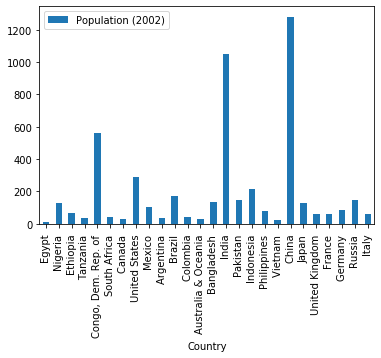

In [110]:
foo_df = pd.DataFrame(foo).astype({'Population (2002)': 'float', 'Project Population (2025)': 'float'})
ax = foo_df.plot.bar(x='Country',y='Population (2002)')

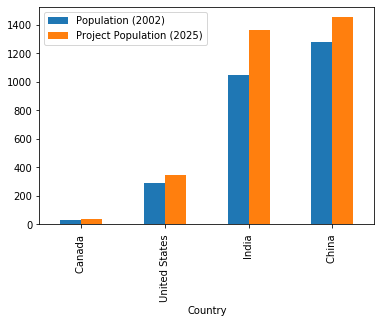

In [130]:
foo_df = pd.DataFrame(foo).astype({'Population (2002)': 'float', 'Project Population (2025)': 'float'})
ax = foo_df.iloc[[6,7,14,19]].plot.bar(x='Country')

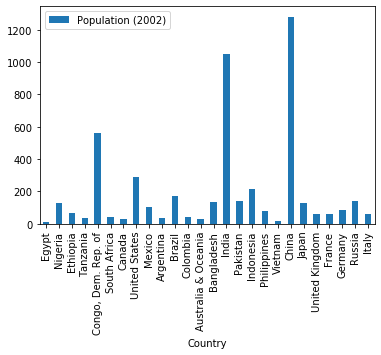

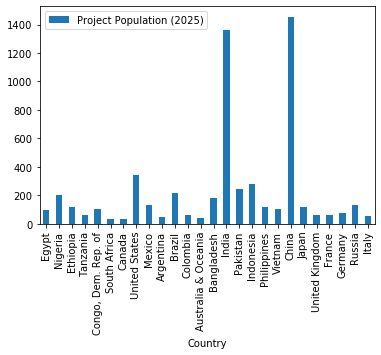

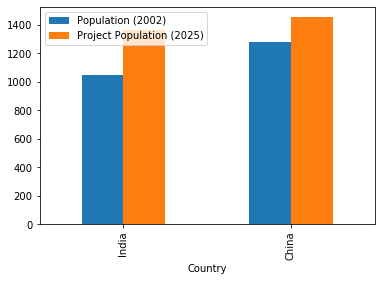

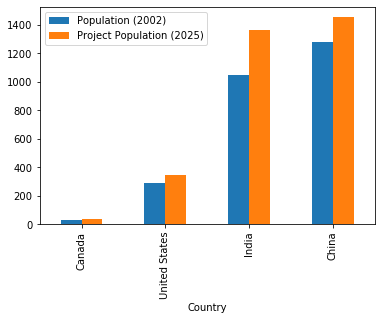

Interesting observation: It seems both China and India have the largest estimate for population in terms of future projection. But let's investigate this further. We have another dataset from World Bank regarding China that we will load and examine further to better understand our initial analysis. 

In [131]:
china = pd.read_csv('Data/China/API_CHN_DS2_en_csv_v2_615059.csv', 
                    skip_blank_lines=True, 
                    skiprows=4)

In [132]:
china.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,China,CHN,"Population ages 40-44, female (% of female pop...",SP.POP.4044.FE.5Y,5.551835,5.478411,5.347071,5.191094,5.052465,4.948230,...,9.407978,9.347677,9.189468,8.947521,8.637590,8.264010,7.826342,7.375617,NaN,NaN
1,China,CHN,"Population ages 35-39, male (% of male populat...",SP.POP.3539.MA.5Y,5.919494,5.905192,5.898749,5.903042,5.919873,5.943034,...,8.500235,8.052052,7.584342,7.176343,6.879643,6.685844,6.583946,6.587374,NaN,NaN
2,China,CHN,"Population ages 35-39, female (% of female pop...",SP.POP.3539.FE.5Y,5.738536,5.677073,5.598823,5.524227,5.477104,5.462105,...,8.548305,8.089537,7.617409,7.206976,6.906939,6.709267,6.604155,6.603480,NaN,NaN
3,China,CHN,"Population ages 30-34, male (% of male populat...",SP.POP.3034.MA.5Y,6.780982,6.841904,6.852674,6.830259,6.799692,6.767670,...,6.912692,6.800519,6.797166,6.916692,7.157209,7.520793,8.025598,8.549579,NaN,NaN
4,China,CHN,"Population ages 30-34, female (% of female pop...",SP.POP.3034.FE.5Y,6.283533,6.328102,6.356205,6.367457,6.360458,6.328613,...,6.935184,6.821417,6.814965,6.928836,7.160112,7.510158,7.998682,8.501577,NaN,NaN


In [133]:
china.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
1424,China,CHN,"PNG, commercial banks and other creditors (NFL...",DT.NFL.PNGC.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.536400e+10,7.360843e+09,4.624714e+09,3.513015e+10,3.299460e+10,6.781624e+09,-3.347714e+09,-5.855178e+09,NaN,NaN
1425,China,CHN,"PNG, bonds (NFL, current US$)",DT.NFL.PNGB.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.310570e+10,1.939326e+10,2.207590e+10,3.498638e+10,-2.766385e+09,1.974929e+10,5.010177e+10,3.169336e+10,NaN,NaN
1426,China,CHN,Commercial banks and other lending (PPG + PNG)...,DT.NFL.PCBO.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.841636e+10,1.594303e+10,1.889475e+10,4.505679e+10,1.977279e+10,1.951698e+10,3.824159e+09,2.005511e+09,NaN,NaN
1427,China,CHN,"PPG, commercial banks (NFL, current US$)",DT.NFL.PCBK.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.703986e+10,9.306825e+09,1.045289e+10,1.033500e+10,-1.145931e+10,1.350918e+10,7.369273e+09,7.800477e+09,NaN,NaN
1428,China,CHN,"PPG, bonds (NFL, current US$)",DT.NFL.PBND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.192363e+10,1.623800e+10,6.405000e+09,1.889375e+10,1.154201e+10,2.523987e+09,3.198586e+10,3.692071e+10,NaN,NaN


There are so many indicators. We just want to focus on two groups: Ages 15-64 we can refer to them as **Adults**, and ages 0-14 we can refer to them as **Children** 

In [137]:
indicators = ['Population ages 15-64, total', 'Population ages 0-14, total']
chinapop = china[china['Indicator Name'].isin(indicators)].iloc[:,:-2]

In [138]:
chinapop

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
10,China,CHN,"Population ages 15-64, total",SP.POP.1564.TO,376823164.0,372520588.0,373118860.0,379332695.0,386528523.0,396196818.0,...,974558542.0,980077454.0,984319837.0,988398458.0,991985917.0,994542472.0,995702268.0,995434082.0,994288090.0,991653198.0
22,China,CHN,"Population ages 0-14, total",SP.POP.0014.TO,265641893.0,263302831.0,268188604.0,278443818.0,287297670.0,294501997.0,...,251102769.0,249615182.0,248796397.0,248118129.0,247587326.0,247401658.0,247557811.0,248085474.0,248682677.0,248978380.0


In [162]:
# let's pick one slice and examine Adults
adults = chinapop.iloc[:1, 4:]
adults

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
10,376823164.0,372520588.0,373118860.0,379332695.0,386528523.0,396196818.0,405508463.0,416669512.0,429726357.0,443537016.0,...,974558542.0,980077454.0,984319837.0,988398458.0,991985917.0,994542472.0,995702268.0,995434082.0,994288090.0,991653198.0


## Q7: Convert the `adults` to the format below (5 pts)
Hint: [pandas melt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html)


In [163]:
## YOUR CODE HERE
adults = adults.melt()

In [150]:
adults

,variable,value
0,1960,376823164.0
1,1961,372520588.0
2,1962,373118860.0
3,1963,379332695.0
4,1964,386528523.0
5,1965,396196818.0
6,1966,405508463.0
7,1967,416669512.0
8,1968,429726357.0
9,1969,443537016.0


## Q7 Rename the column `variable` to `year` (5 pts)

In [164]:
# rename the columns

adults = adults.rename(columns={'variable': 'year'})

We will set `year` as the DataFrame Index to get a Time Series plot

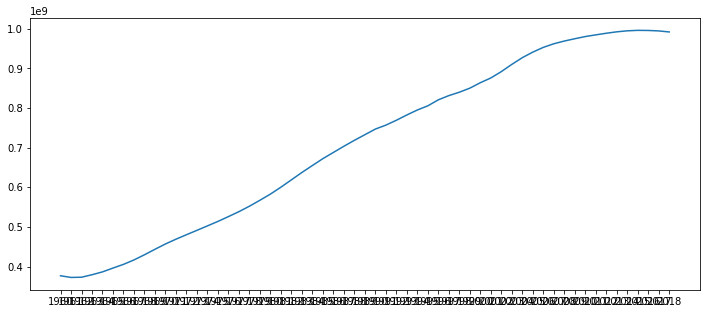

In [165]:
adults = adults.set_index('year')
plt.figure(figsize=(12,5))
plt.plot(adults)

The graph has many issues. In order for Pandas to recognize this as a Time Series, the index which is currently as `object` needs to be converted to a `datetime`

In [153]:
adults.index

Index(['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018'],
      dtype='object', name='year')

## Q8: Convert the index to datetime (5 pts)

In [166]:
#YOUR CODE HERE
adults.index = adults.index.astype('datetime64')

In [168]:
adults.index

DatetimeIndex(['1960-01-01', '1961-01-01', '1962-01-01', '1963-01-01',
               '1964-01-01', '1965-01-01', '1966-01-01', '1967-01-01',
               '1968-01-01', '1969-01-01', '1970-01-01', '1971-01-01',
               '1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01',
               '1976-01-01', '1977-01-01', '1978-01-01', '1979-01-01',
               '1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1984-01-01', '1985-01-01', '1986-01-01', '1987-01-01',
               '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
      

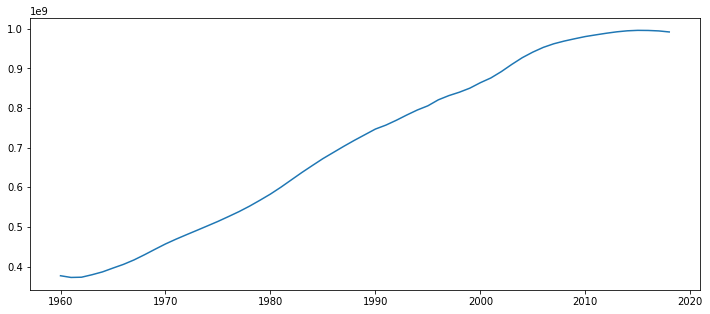

In [169]:
# Let's try the plot again
plt.figure(figsize=(12,5))
plt.plot(adults)

## Q9: Follow the sames steps but this time for the children (15 pts)

In [177]:
children = chinapop.iloc[1:2, 4:]

# YOUR CODE HERE
children = children.melt().rename(columns={'variable': 'year'}).set_index('year')
children.index = children.index.astype('datetime64')

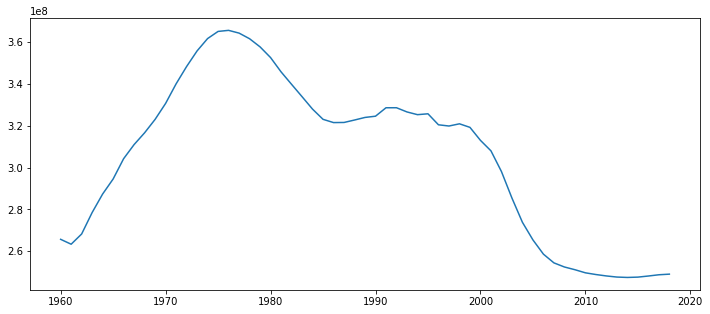

In [176]:
plt.figure(figsize=(12,5))
plt.plot(children)

## Q10: I was able to combine into one chart. When you look at this, do you see any alarming trend? What are your thoughts? (5 pts)


<img src="images/analysis.png"/>

* While there has been a steady increase in adult population over the span of this data, the population of children has been declining from the middle of the 1970's until the 2010's.  
  
  
* This coincides with China's "One Child Policy" which was enacted in 1979, after a decade of a "Two Child Policy".  It is likely that China will soon be facing many problems associated with a much larger elderly population and not enough people to help take care of them.  With the economic boom China has been experiencing in recent years this will be especially so since many of those living in more rural areas are leaving their home towns for better jobs and opportunities in more urban areas, leaving no one to take care of the elderly in the towns they left. 